# Introduction to GIS: tutorial with GeoPandas in Python
### yueyanw @ LEAP-SIG-DS 10-12-2017       



## 1. Import GeoPandas Module
"GeoPandas is a perfect marriage between shapefiles and dataframes".

In [82]:
%matplotlib inline 
import geopandas as gpd
import matplotlib.pyplot as plt

## 2. GeoDataFrame 
- GeoPandas makes reading spatial data very easy, and saves it as GeoDataFrames.  
- Shapefile is a commonly avaiable spatial data format, native to proprietary ArcGIS software by esri.  
- ArcGIS has Point-and-Click interface. It can be called in Python by the ArcPy package.   
- Alternatives, QGIS, R, Python, SAS etc.
- Common vector shapes: point, line, and polygon. 

In [83]:
#read country GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [84]:
# Examine country GeoDataFrame
# The special column is geometry
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


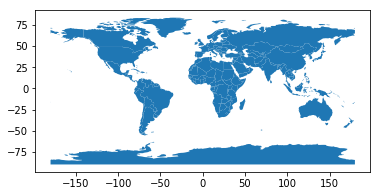

In [85]:
# show polygon shapes
world.plot()

In [86]:
# cities as point shapes
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities.head()

,name,geometry
0,Vatican City,POINT (12.45338654497177 41.90328217996012)
1,San Marino,POINT (12.44177015780014 43.936095834768)
2,Vaduz,POINT (9.516669472907267 47.13372377429357)
3,Luxembourg,POINT (6.130002806227083 49.61166037912108)
4,Palikir,POINT (158.1499743237623 6.916643696007725)


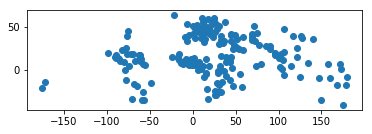

In [87]:
# show point shapes
cities.plot()

## 3. Data Manipulation on GeoDataFrame
It's just like operating on a DataFrame for selection, create new variables etc.

In [88]:
# Select only inhabited continents
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

# Calculate GDP per capita for each country
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,gdp_per_cap
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",0.000784
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,0.008618
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",0.005993
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",0.038408
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,0.014027


## 4.  Choropleth Maps
Maps where the color of each shape is based on the value of an associated variable.


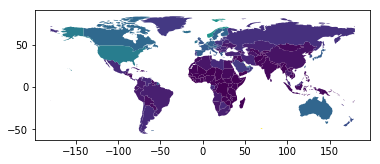

In [89]:
# a simple map for gdp per capita
# column argument specifies the variable the color is based on
world.plot(column='gdp_per_cap')

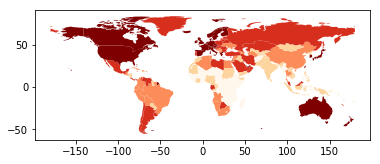

In [91]:
# choose colors
# choose a scheme: By default, scheme is set to ‘equal_intervals’, other options: ‘quantiles’, ‘percentiles’, etc
world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles')

## 5. Maps with multiple Layers
Put Countries and Cities in the same map.

### coordinate reference system and projection
- One important attribute for geometries.
- Especially important when combining spatial data from different sources.

In [56]:
# Need to make sure the two sources have the same crs.
# Check crs of the world GeoDataFrame
world.crs

{'init': 'epsg:4326'}

In [57]:
# Check crs of the cities GeoDataFrame
cities.crs

{'init': 'epsg:4326'}

In [58]:
# or do this

world.crs == cities.crs

True

In [59]:
# luckily they are the same
# If not, we can convert the crs to be the same
cities = cities.to_crs(world.crs)

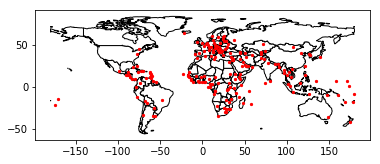

In [60]:
# overlay cities over country outlines
base = world.plot(color='white', edgecolor='black')
cities.plot(ax=base, marker='o', color='red', markersize=5)

### Map in a different crs

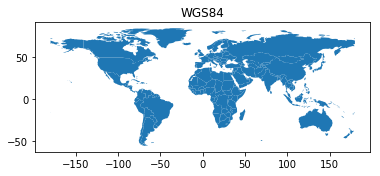

In [61]:
# Visualize of the initial projection
ax = world.plot()
ax.set_title("WGS84")

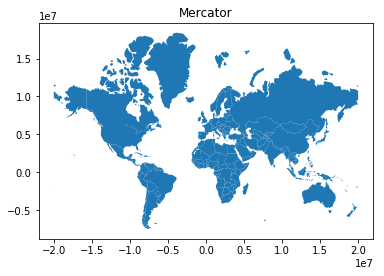

In [62]:
# Reproject to Mercator 
# This is the projection Google Maps use, which preserves angles, but not area or distance
world = world.to_crs({'init': 'epsg:3395'}) # world.to_crs(epsg=3395) would also work

# Visualize of the new projection
ax = world.plot()
ax.set_title("Mercator")

## 6. Geoprocessing
- Spatial Join
- buffer
- dissolve

In [79]:
# Spatial Join
# Linking data through spatial key
cities_with_country = gpd.sjoin(cities, world, how="inner", op='intersects')
cities_with_country.head()

,name_left,geometry,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est
0,Vatican City,POINT (12.45338654497177 41.90328217996012),79,58126212.0,Europe,Italy,ITA,1823000.0
1,San Marino,POINT (12.44177015780014 43.936095834768),79,58126212.0,Europe,Italy,ITA,1823000.0
192,Rome,POINT (12.481312562874 41.89790148509894),79,58126212.0,Europe,Italy,ITA,1823000.0
2,Vaduz,POINT (9.516669472907267 47.13372377429357),9,8210281.0,Europe,Austria,AUT,329500.0
184,Vienna,POINT (16.36469309674374 48.20196113681686),9,8210281.0,Europe,Austria,AUT,329500.0


In [64]:
# Select South Amarica and then select geometry and name columns
countries = world[world['continent'] == "South America"]
countries = countries[['geometry', 'name']]

# Project to crs that uses meters as distance measure
countries = countries.to_crs('+init=epsg:3395')
capitals = cities.to_crs('+init=epsg:3395')

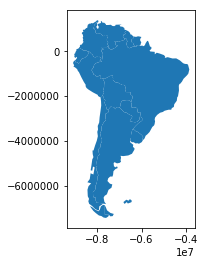

In [65]:
#check countries: World Mercator, units of meters
countries.plot()

### Buffer

In [66]:
# buffer cities to find area within 500 km
capitals['geometry']= capitals.buffer(500000)

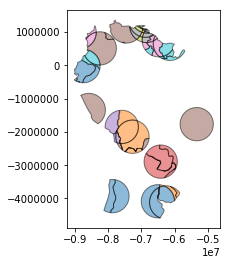

In [67]:
# intersection with countries
country_cores = gpd.overlay(countries, capitals, how='intersection')
country_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10')

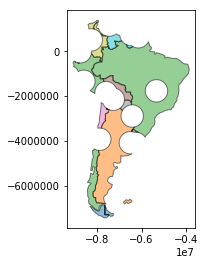

In [68]:
# difference with countries
country_peripheries = gpd.overlay(countries, capitals, how='difference')
country_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10')

### Aggregation countries to continents, Dissolve

In [69]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[['continent', 'geometry']]
continents = world.dissolve(by='continent')
continents.head()

,geometry
continent,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...
Antarctica,(POLYGON ((-159.2081835601977 -79.497059421708...
Asia,(POLYGON ((120.7156087586305 -10.2395813940878...
Europe,(POLYGON ((-52.55642473001839 2.50470530843705...
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."


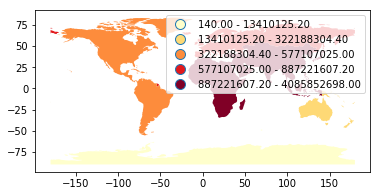

In [80]:
#aggregate populations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[['continent', 'geometry', 'pop_est']]
continents = world.dissolve(by='continent', aggfunc='sum')
continents.plot(column = 'pop_est', scheme='quantiles', cmap='YlOrRd', legend=True)

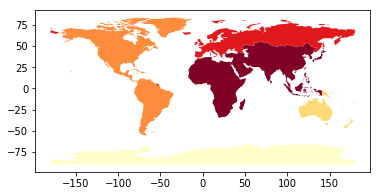

In [71]:
#output the map to a png file
continents.plot(column = 'pop_est', scheme='quantiles', cmap='YlOrRd')
plt.savefig("populations.png",format='PNG')

In [72]:
#dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# For attribute join
country_shapes = world[['geometry', 'iso_a3']]
country_names = world[['name', 'iso_a3']]

# For spatial join
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'}) #rename column "name" as "country"

In [73]:
#check country shapes
country_shapes.head()

,geometry,iso_a3
0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG
1,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO
2,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB
3,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE
4,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG


In [74]:
#check country names
country_names.head()

,name,iso_a3
0,Afghanistan,AFG
1,Angola,AGO
2,Albania,ALB
3,United Arab Emirates,ARE
4,Argentina,ARG


In [75]:
#attribute join of conntry names to country shapes and check the new country_shapes
country_shapes = country_shapes.merge(country_names, on='iso_a3')
country_shapes.head()

,geometry,iso_a3,name
0,"POLYGON ((61.21081709172574 35.65007233330923,...",AFG,Afghanistan
1,(POLYGON ((16.32652835456705 -5.87747039146621...,AGO,Angola
2,"POLYGON ((20.59024743010491 41.85540416113361,...",ALB,Albania
3,"POLYGON ((51.57951867046327 24.24549713795111,...",ARE,United Arab Emirates
4,(POLYGON ((-65.50000000000003 -55.199999999999...,ARG,Argentina


## References to Geo-statistics
ArcGIS/esri has pretty good documentation on various GIS techniques. 
- hot spot analysis
  http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-how-hot-spot-analysis-getis-ord-gi-spatial-stati.htm
- kriging
  This is the interpolation modeling I mentioned. https://en.wikipedia.org/wiki/Kriging
  http://desktop.arcgis.com/en/arcmap/10.3/tools/3d-analyst-toolbox/how-kriging-works.htm

## Other Resources
- Census Geo data and population data
  https://www.census.gov/geo/maps-data/data/tiger-line.html
- GeoPandas documentation
  http://geopandas.org/